In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS        Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-03  26047        Emmet County          MI                      68.1                   22751            71.8           23985.0
1        2021-11-03   8049        Grand County          CO                      57.2                    9006            64.5           10156.0
2        2021-11-03  23031         York County          ME                      72.0                  149599            79.4          164825.0
3        2021-11-03  51115      Mathews County          VA                      56.1                    4958            61.5            5431.0
4        2021-11-03  38035  Grand Forks County          ND                      50.6                   35122            58.4           40548.0
...             ...    ...                 ...         ...                       ...                     ...             ...               ...
1069943  2020-12-13  35003       Catron County          NM                       0.0                       0             0.0               0.0
1069944  2020-12-13  51125       Nelson County          VA                       0.0                       0             0.0               0.0
1069946  2020-12-13  45067       Marion County          SC                       0.0                       0             0.0               0.0
1069947  2020-12-13  47041       DeKalb County          TN                       0.0                       0             0.0               0.0
1069948  2020-12-13  49045       Tooele County          UT                       0.0                       0             0.0               0.0

[1013415 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
278      MN  2020-01-01            0.0                0.0        46.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
27297    HI  2020-01-01            0.0                0.0         0.0        0.0              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
25996    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
29095    PR  2020-01-01            0.0                0.0       146.0       61.0              0.0            NaN        NaN               NaN              NaN        NaN       0.417808   
31201    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
20857    WA  2021-11-03           19.0               10.0     10925.0     9132.0           1247.0          936.0      322.0            1223.0             24.0     1215.0       0.835881   
16888    OK  2021-11-03           37.0                2.0      8674.0     5945.0            534.0          728.0      163.0             516.0             18.0      897.0       0.685382   
15439    TN  2021-11-03           27.0               33.0     18493.0    13121.0            991.0         1667.0      303.0             982.0              9.0     2405.0       0.709512   
17143    NV  2021-11-03            2.0               29.0      8440.0     6434.0            654.0          645.0      150.0             650.0              4.0      811.0       0.762322   
12827    NE  2021-11-03           18.0                4.0      3922.0     2943.0            458.0          391.0      140.0             444.0             14.0      474.0       0.750957   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
278                   NaN             NaN       NaN           NaN        NaN        NaN        NaN  
27297                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
25996            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
29095            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
31201            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
20857            0.135306        0.113213  0.262144      0.770370      660.0       69.0       51.0  
16888            0.091926        0.062764  0.190643      0.811594     5093.0     1969.0     2443.0  
15439            0.077007        0.054540  0.130999      0.693139      360.0        4.0      108.0  
17143            0.103744        0.078729  0.191327      0.795314     1118.0      557.0      557.0  
12827            0.157822        0.118469  0.303030      0.824895      939.0      443.0      684.0  

[32789 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.0
71.4


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     9061156                       0                 0       610047       7757       7479          92    12295.142857       162.000000     135.690665   
1          1      0 2020-12-29  total_40     9061156                       0                 0       617024       7819      11271         147    12247.571429       164.500000     135.165661   
2          2      0 2020-12-30  total_40     9061156                       0                 0       625042       7900      14995         143    12320.785714       160.357143     135.973663   
3          3      0 2020-12-31  total_40     9061156                       0                 0       632046       8039      15022         220    12324.714286       157.714286     136.017019   
4          4      0 2021-01-01  total_40     9061156                       0                 0       639053       8107      14011         207    12128.357143       157.000000     133.849998   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
305      305      0 2021-10-29  total_40     9061156                 3962017           4713488      1495947      24666       7333         213     7491.142857       158.214286      82.673147   
306      306      0 2021-10-30  total_40     9061156                 3966870           4719631      1497702      24711       4632         135     7304.285714       155.214286      80.610970   
307      307      0 2021-10-31  total_40     9061156                 3969894           4723536      1498821      24711       2874          45     7191.785714       155.428571      79.369406   
308      308      0 2021-11-01  total_40     9061156                 3972592           4727313      1501233      24768       3531          57     7083.071429       154.642857      78.169622   
309      309      0 2021-11-02  total_40     9061156                 3975294           4731256      1503835      24888       5014         177     6946.285714       150.357143      76.660039   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.787851                  0.000000        0.000000  
1          1.815442                  0.000000        0.000000  
2          1.769721                  0.000000        0.000000  
3          1.740554                  0.000000        0.000000  
4          1.732671                  0.000000        0.000000  
..              ...                       ...             ...  
305        1.746072                  0.437253        0.520186  
306        1.712963                  0.437789        0.520864  
307        1.715328                  0.438122        0.521295  
308        1.706657                  0.438420        0.521712  
309        1.659359                  0.438718        0.522147  

[310 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 54, 56], 'state': ['AL', 'ID', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 28, 29, 38, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MS', 'MO', 'ND', 'TN']}, 50: {'FIPS': [4, 20, 21, 26, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'KS', 'KY', 'MI', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [12, 19, 31, 55], 'state': ['FL', 'IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 36], 'state': ['MD', 'MA', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc             FIPS      tier total_beds beds_used  \
16      9061156 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
17      9061156 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
18      9061156 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
19      9061156 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
20      9061156 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..              ...       ...        ...       ...   
3901    6592849 2021-10-29     13148      725447      3122         27     2425.285714     36.786611        28.571429        0.43337  CT  [9, 23, 44, 50]  total_70    15373.0   12267.0   
3902    6592849 2021-10-30     13152      726170      2240         24     2418.142857     36.678268        27.571429       0.418202  CT  [9, 23, 44, 50]  total_70    15424.0   11995.0   
3903    6592849 2021-10-31     13152      726438       991          4     2401.428571     36.424747        27.142857       0.411701  CT  [9, 23, 44, 50]  total_70    15375.0   11684.0   
3904    6592849 2021-11-01     13159      727977      1807          7     2406.571429     36.502754        28.142857       0.426869  CT  [9, 23, 44, 50]  total_70    14476.0   11035.0   
3905    6592849 2021-11-02     13181      729648      3210         29     2449.142857     37.148475        26.142857       0.396534  CT  [9, 23, 44, 50]  total_70    14485.0   11481.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
16               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
17               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
18               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
19               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
20               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3901           564.0    1614.0  0.507313690796838     158.0            559.0             5.0        36.786611           0.43337  
3902           578.0    1619.0   0.50309551862097     151.0            569.0             9.0        36.678268          0.418202  
3903           557.0    1612.0  0.447522925575096     151.0            552.0             5.0        36.424747          0.411701  
3904           583.0    1610.0  0.467790025550097     152.0            574.0             9.0        36.502754          0.426869  
3905           602.0    1604.0  0.528521664269863     159.0            590.0            12.0        37.148475          0.396534  

[4445 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1048944      17836       16926        115    23564.428571   
335  2020-12-22  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1063082      18052       21429        266    23672.428571   
336  2020-12-23  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1076133      18261       27189        425    23800.714286   
337  2020-12-24  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1090814      18443       27732        391    23937.000000   
338  2020-12-25  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1098729      18548       22596        287    23089.714286   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
646  2021-10-29  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3171815      52280        9761         82     6743.000000   
647  2021-10-30  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3172871      52277        7237         42     6802.714286   
648  2021-10-31  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3173622      52282        1807          2     6770.428571   
649  2021-11-01  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3180304      52329        7433         52     7084.285714   
650  2021-11-02  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3183081      52360        9459         78     7164.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       289.285714      125.2661       1.537813              100          1.537813                      0.0                      0            0.0              0.0  total_30  
335       290.285714    125.840217       1.543129              100          1.543129                      0.0                      0            0.0              0.0  total_30  
336       295.571429     126.52217       1.571228              100          1.571228                      0.0                      0            0.0              0.0  total_30  
337       294.285714    127.246651       1.564393              100          1.564393                      0.0                      0            0.0              0.0  total_30  
338       288.285714    122.742567       1.532497              100          1.532497                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
646        69.285714     24.659139       0.253378        24.659139          0.253378                73.201729               20016889       81.81585       22372406.0  total_70  
647        67.142857     24.877514       0.245541        24.877514          0.245541                73.269113               20035315      81.919033       22400621.0  total_70  
648        65.428571     24.759446       0.239272        24.759446          0.239272                73.338321               20054240      82.015702       22427055.0  total_7

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
16   2020-02-07  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
17   2020-02-08  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
18   2020-02-09  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
19   2020-02-10  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
646  2021-10-29  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3171815      52280        9761         82     6743.000000   
647  2021-10-30  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3172871      52277        7237         42     6802.714286   
648  2021-10-31  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3173622      52282        1807          2     6770.428571   
649  2021-11-01  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3180304      52329        7433         52     7084.285714   
650  2021-11-02  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3183081      52360        9459         78     7164.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
646        69.285714     24.659139       0.253378        24.659139          0.253378  total_70  
647        67.142857     24.877514       0.245541        24.877514          0.245541  total_70  
648        65.428571     24.759446       0.239272        24.759446          0.239272  total_70  
649        65.142857     25.907221       0.238227        25.907221          0.238227  total_70  
650        61.571429     26.198736       0.225167        26.198736          0.225167  total_70  

[5724 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS Admin2 Province_State       Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669           1          0           0          0        0.000000         0.000000   
16   2020-02-07  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669           1          0           0          0        0.000000         0.000000   
17   2020-02-08  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669           1          0           0          0        0.000000         0.000000   
18   2020-02-09  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669           1          0           0          0        0.000000         0.000000   
19   2020-02-10  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669           1          0           0          0        0.000000         0.000000   
..          ...                                                ...    ...            ...                ...        ...         ...        ...         ...        ...             ...              ...   
646  2021-10-29  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669     8402955     118414       34729        512    28151.857143       444.000000   
647  2021-10-30  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669     8407937     118489       24600        391    28126.285714       447.571429   
648  2021-10-31  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669     8411678     118515        8723        101    28303.857143       450.428571   
649  2021-11-01  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669     8436886     118737       28949        248    29217.714286       451.142857   
650  2021-11-02  [6101, 12017, 19059, 28049, 51125, 46047, 2805...   Hale        Alabama  Hale, Alabama, US   57230669     8449138     118971       37460        456    29558.571429       445.142857   

    case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15            0.0            0.0              0.0               0.0  total_50  
16            0.0            0.0              0.0               0.0  total_50  
17            0.0            0.0              0.0               0.0  total_50  
18            0.0            0.0              0.0               0.0  total_50  
19            0.0            0.0              0.0               0.0  total_50  
..            ...            ...              ...               ...       ...  
646     49.190159       0.775808        49.190159          0.775808  total_50  
647     49.145478       0.782048        49.145478          0.782048  total_50  
648     49.455751       0.787041        49.455751          0.787041  total_50  
649     51.052547       0.788289        51.052547          0.788289  total_50  
650     51.648132       0.777805        51.648132          0.777805  total_50  

[636 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10241.056307
1    10944.996012
2    10578.726117
3    10765.738088
4    10520.341812
5     9654.148540
6    10129.859423
7     9745.371720
8     9270.179801
Name: confirm_period_100k, dtype: float64
9     4939.325137
10    5444.273853
11    5141.684302
12    4416.622576
13    4238.461724
14    3514.674310
15    2846.813560
16    2170.214608
17    2367.526060
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.068737
2    1.032972
3    1.051233
4    1.027271
5    0.942691
6    0.989142
7    0.951598
8    0.905198
Name: confirm_period_100k, dtype: float64
9     1.000000
10    1.102230
11    1.040969
12    0.894175
13    0.858105
14    0.711570
15    0.576357
16    0.439375
17    0.479322
Name: confirm_period_100k, dtype: float64
[ 0.         -0.03349328 -0.00799682  0.15705786  0.16916573  0.23112096
  0.41278526  0.51222357  0.42587585]
0    197.517508
1    208.825203
2    195.533228
3    191.035003
4    169.928120
5    150.443538
6    196.649259
7

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18811497  0.057704  2020-02-06  2021-06-30         1926496         10241.056307           37156         197.517508
1      0  total_35  start    16702007  0.051233  2020-02-06  2021-06-30         1828034         10944.996012           34878         208.825203
2      0  total_40  start    24809594  0.076103  2020-02-06  2021-06-30         2624539         10578.726117           48511         195.533228
3      0  total_45  start    35279922  0.108221  2020-02-06  2021-06-30         3798144         10765.738088           67397         191.035003
4      0  total_50  start    57230669  0.175555  2020-02-06  2021-06-30         6020862         10520.341812           97251         169.928120
5      0  total_55  start    56260974  0.172581  2020-02-06  2021-06-30         5431518          9654.148540           84641         150.443538
6      0  total_60  start    66250949  0.203225  2020-02-06  2021-06-30         6711128         10129.859423          130282         196.649259
7      0  total_65  start    23307741  0.071497  2020-02-06  2021-06-30         2271426          9745.371720           44261         189.898283
8      0  total_70  start    27344831  0.083880  2020-02-06  2021-06-30         2534915          9270.179801           49650         181.569965

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18811497  0.057704  2020-02-06  2021-06-30         1926496         10241.056307           37156         197.517508
1      0  total_35  start    16702007  0.051233  2020-02-06  2021-06-30         1828034         10944.996012           34878         208.825203
2      0  total_40  start    24809594  0.076103  2020-02-06  2021-06-30         2624539         10578.726117           48511         195.533228
3      0  total_45  start    35279922  0.108221  2020-02-06  2021-06-30         3798144         10765.738088           67397         191.035003
4      0  total_50  start    57230669  0.175555  2020-02-06  2021-06-30         6020862         10520.341812           97251         169.928120
5      0  total_55  start    56260974  0.172581  2020-02-06  2021-06-30         5431518          9654.148540           84641         150.443538
6      0  total_60  start    66250949  0.203225  2020-02-06  2021-06-30         6711128         10129.859423          130282         196.649259
7      0  total_65  start    23307741  0.071497  2020-02-06  2021-06-30         2271426          9745.371720           44261         189.898283
8      0  total_70  start    27344831  0.083880  2020-02-06  2021-06-30         2534915          9270.179801           49650         181.569965

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
1509     2021-11-03  35031  McKinley County          NM                      72.3                   51625            91.0           64921.0
4018     2021-11-02  35031  McKinley County          NM                      72.3                   51583            90.8           64804.0
9827     2021-11-01  35031  McKinley County          NM                      72.3                   51575            90.8           64790.0
11107    2021-10-31  35031  McKinley County          NM                      72.2                   51527            90.6           64680.0
13612    2021-10-30  35031  McKinley County          NM                      72.1                   51450            90.3           64471.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1055508  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1057866  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1062469  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1064072  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1069903  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[326 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 893788,
  'confirm_start': 610047,
  'confirm_end': 1503835,
  'confirm_period_100k': 9863.951133828841,
  'confirm_deaths': 17131,
  'death_period_100k': 189.05976235261815,
  'vax_complete': 3975294,
  'vax_complete_100k': 43871.81944555419,
  'vax_partial': 4731256,
  'vax_partial_100k': 52214.7063796275,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 41721053,
  'pop_pct': 0.12751770819271183,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 3757724,
  'confirm_start': 2914236,
  'confirm_end': 6671960,
  'confirm_period_100k': 9006.781300558257,
  'confirm_deaths': 60631,
  'death_period_100k': 145.32471172288004,
  'vax_complete': 20180437,
  'vax_complete_100k': 48369.91290704,
  '

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0277 confirm 100k:9863 Death 100k:189 Vaccine 100k:43871
total_45 pop pct:0.1275 confirm 100k:9006 Death 100k:145 Vaccine 100k:48369
total_50 pop pct:0.2848 confirm 100k:8650 Death 100k:136 Vaccine 100k:52678
total_55 pop pct:0.099 confirm 100k:9653 Death 100k:73 Vaccine 100k:58957
total_60 pop pct:0.3147 confirm 100k:6853 Death 100k:103 Vaccine 100k:61187
total_65 pop pct:0.1463 confirm 100k:7392 Death 100k:95 Vaccine 100k:67664


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 825262,
  'confirm_start': 678573,
  'confirm_end': 1503835,
  'confirm_period_100k': 9107.690012179462,
  'confirm_deaths': 16284,
  'death_period_100k': 179.7121691757652,
  'vax_complete': 3975294,
  'vax_complete_100k': 43871.81944555419,
  'vax_partial': 4731256,
  'vax_partial_100k': 52214.7063796275,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 41721053,
  'pop_pct': 0.12751770819271183,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 3425006,
  'confirm_start': 3246954,
  'confirm_end': 6671960,
  'confirm_period_100k': 8209.29903183412,
  'confirm_deaths': 56360,
  'death_period_100k': 135.08767384178918,
  'vax_complete': 20180437,
  'vax_complete_100k': 48369.91290704,
  'va

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     9061156  0.027847 2020-02-07 2021-06-30          972312         10730.551378           17142         189.181160
0  total_45   start    41721053  0.128220 2020-02-07 2021-06-30         4599062         11023.360316           82022         196.596188
0  total_50   start    93164862  0.286321 2020-02-07 2021-06-30         9717214         10430.127616          165666         177.820260
0  total_55   start    32389649  0.099542 2020-02-07 2021-06-30         3641435         11242.588643           53469         165.080517
0  total_60   start   101182854  0.310962 2020-02-07 2021-06-30         9414635          9304.575457          155975         154.151611
0  total_65   start    41273934  0.126846 2020-02-07 2021-06-30         4307691         10436.831633          107612         260.726298
0  total_70   start     6592849  0.020262 2020-02-07 2021-06-30          595409          9031.133581           12111         183.699035
0  total_40  summer     9061156  0.027847 2021-07-01 2021-11-02          531313          5863.633735            7738          85.397492
0  total_45  summer    41721053  0.128220 2021-07-01 2021-11-02         2069089          4959.340312           26403          63.284596
0  total_50  summer    93164862  0.286321 2021-07-01 2021-11-02         3902991          4189.338036           48378          51.927303
0  total_55  summer    32389649  0.099542 2021-07-01 2021-11-02         1715025          5294.978652            2158           6.662622
0  total_60  summer   101182854  0.310962 2021-07-01 2021-11-02         2937621          2903.279443           26376          26.067658
0  total_65  summer    41273934  0.126846 2021-07-01 2021-11-02          875130          2120.297038            6759          16.375953
0  total_70  summer     6592849  0.020262 2021-07-01 2021-11-02          134176          2035.174778            1067          16.184202

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10241.056307
1    10944.996012
2    10578.726117
3    10765.738088
4    10520.341812
5     9654.148540
6    10129.859423
7     9745.371720
8     9270.179801
Name: confirm_period_100k, dtype: float64
9     4939.325137
10    5444.273853
11    5141.684302
12    4416.622576
13    4238.461724
14    3514.674310
15    2846.813560
16    2170.214608
17    2367.526060
Name: confirm_period_100k, dtype: float64
0    0.482306
1    0.497421
2    0.486040
3    0.410248
4    0.402883
5    0.364058
6    0.281032
7    0.222692
8    0.255392
dtype: float64
0    0.379616
1    0.360284
2    0.347797
3    0.267312
4    0.222743
5    0.188112
6    0.101756
7    0.075642
8    0.054340
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    18811497  0.057813  2020-02-06  2021-06-30         1926496         10241.056307           37156         197.517508
1       0  total_35   start    16702007  0.051330  2020-02-06  2021-06-30         1828034         10944.996012           34878         208.825203
2       0  total_40   start    24809594  0.076247  2020-02-06  2021-06-30         2624539         10578.726117           48511         195.533228
3       0  total_45   start    35279922  0.108425  2020-02-06  2021-06-30         3798144         10765.738088           67397         191.035003
4       0  total_50   start    57230669  0.175885  2020-02-06  2021-06-30         6020862         10520.341812           97251         169.928120
5       0  total_55   start    56260974  0.172905  2020-02-06  2021-06-30         5431518          9654.148540           84641         150.443538
6       0  total_60   start    66250949  0.203607  2020-02-06  2021-06-30         6711128         10129.859423          130282         196.649259
7       0  total_65   start    23307741  0.071631  2020-02-06  2021-06-30         2271426          9745.371720           44261         189.898283
8       0  total_70   start    27344831  0.084038  2020-02-06  2021-06-30         2534915          9270.179801           49650         181.569965
9       0  total_30  summer    18811497  0.057813  2021-07-01  2021-11-02          929161          4939.325137           14105          74.980742
10      0  total_35  summer    16702007  0.051330  2021-07-01  2021-11-02          909303          5444.273853           12566          75.236467
11      0  total_40  summer    24809594  0.076247  2021-07-01  2021-11-02         1275631          5141.684302           16872          68.005950
12      0  total_45  summer    35279922  0.108425  2021-07-01  2021-11-02         1558181          4416.622576           18016          51.065873
13      0  total_50  summer    57230669  0.175885  2021-07-01  2021-11-02         2425700          4238.461724           21662          37.850335
14      0  total_55  summer    56260974  0.172905  2021-07-01  2021-11-02         1977390          3514.674310           15922          28.300257
15      0  total_60  summer    66250949  0.203607  2021-07-01  2021-11-02         1886041          2846.813560           13257          20.010279
16      0  total_65  summer    23307741  0.071631  2021-07-01  2021-11-02          505828          2170.214608            3348          14.364326
17      0  total_70  summer    27344831  0.084038  2021-07-01  2021-11-02          647396          2367.526060            2698           9.866581

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
323        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
322        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
321        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
320        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
319        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS         Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-03  26047         Emmet County          MI                      68.1                   22751            71.8           23985.0  total_65
1        2021-11-02  26047         Emmet County          MI                      68.1                   22743            71.8           23976.0  total_65
2        2021-11-01  26047         Emmet County          MI                      68.1                   22742            71.7           23975.0  total_65
3        2021-10-31  26047         Emmet County          MI                      68.0                   22737            71.7           23967.0  total_65
4        2021-10-30  26047         Emmet County          MI                      68.0                   22717            71.7           23944.0  total_65
...             ...    ...                  ...         ...                       ...                     ...             ...               ...       ...
1010476  2020-12-17  12057  Hillsborough County          FL                       0.0                       0             0.0               0.0  total_50
1010477  2020-12-16  12057  Hillsborough County          FL                       0.0                       0             0.0               0.0  total_50
1010478  2020-12-15  12057  Hillsborough County          FL                       0.0                       0             0.0               0.0  total_50
1010479  2020-12-14  12057  Hillsborough County          FL                       0.0                       0             0.0               0.0  total_50
1010480  2020-12-13  12057  Hillsborough County          FL                       0.0                       0             0.0               0.0  total_50

[1010481 rows x 9 columns]

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

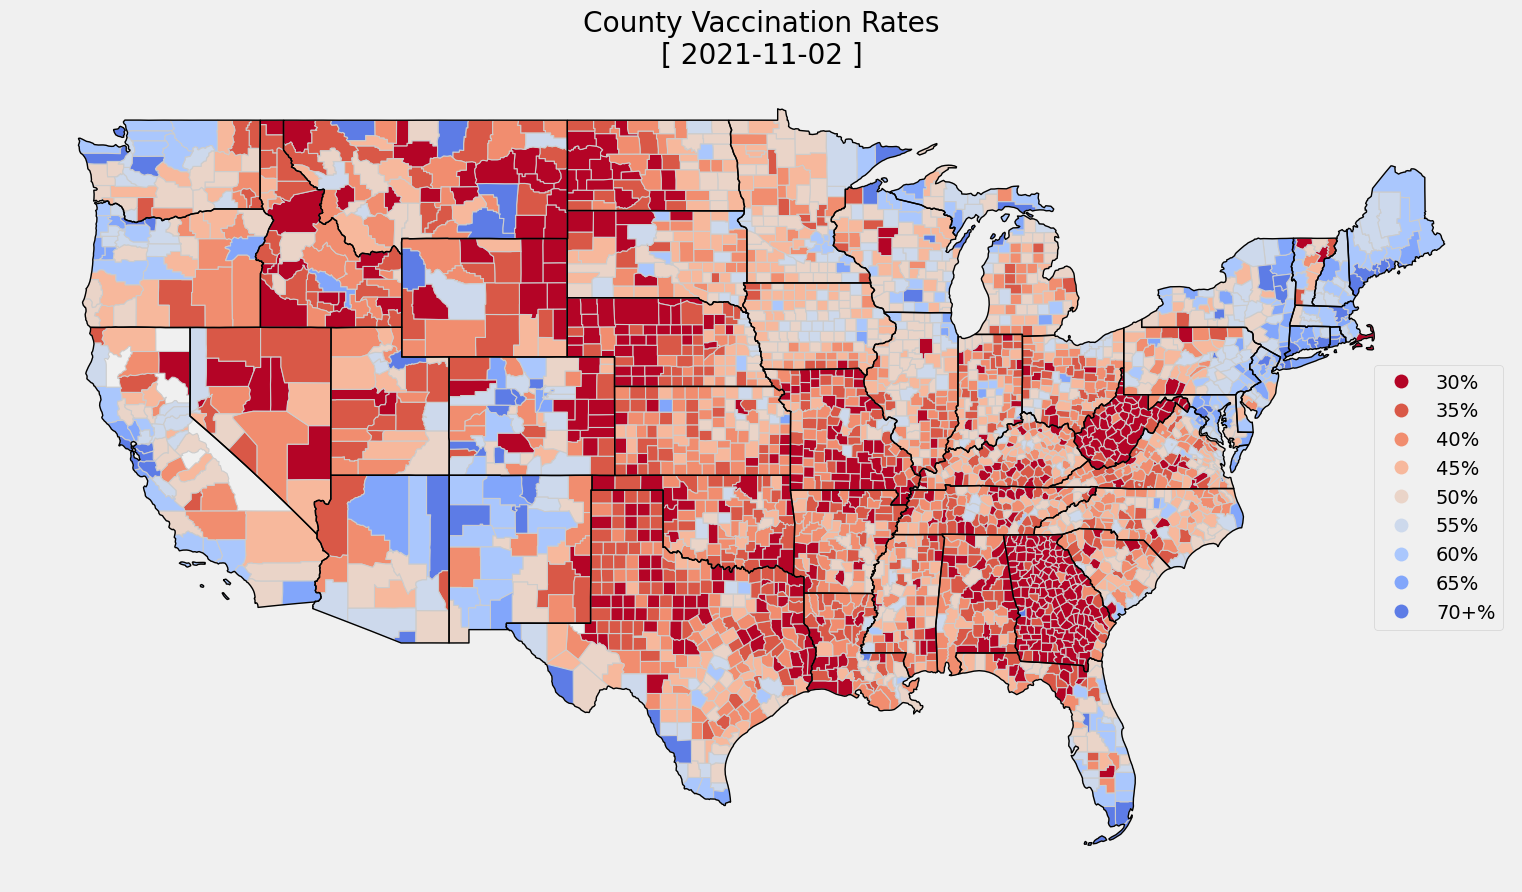

In [29]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


#outfilename=f'z_blog_natl_county_vax.jpg'
#out_blog_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")





In [30]:
geo_county_tier_df

STATEFP  GEOID      NAME                                           geometry   FIPS      tier
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  37017  total_40
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  37167  total_35
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  39153  total_55
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  42113  total_45
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30
...       ...    ...       ...                                                ...    ...       ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35

[3099 rows x 6 columns]

In [31]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 124


{'start_daily_100k_confirm': 0    10241
 1    10944
 2    10578
 3    10765
 4    10520
 5     9654
 6    10129
 7     9745
 8     9270
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9270,
 'start_daily_100k_confirm_max': 10944,
 'start_daily_mean_confirm': 0     3770.050881
 1     3577.365949
 2     5136.084149
 3     7432.767123
 4    11782.508806
 5    10629.193738
 6    13133.322896
 7     4445.060665
 8     4960.694716
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7493.233871
 10     7333.088710
 11    10287.346774
 12    12565.975806
 13    19562.096774
 14    15946.693548
 15    15210.008065
 16     4079.258065
 17     5220.935484
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     72.712329
 1     68.254403
 2     94.933464
 3    131.892368
 4    190.315068
 5    165.637965
 6    254.954990
 7     86.616438
 8     97.162427
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     113.7

In [32]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10241
 1    10944
 2    10578
 3    10765
 4    10520
 5     9654
 6    10129
 7     9745
 8     9270
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9270,
 'start_daily_100k_confirm_max': 10944,
 'start_daily_mean_confirm': 0     3770.050881
 1     3577.365949
 2     5136.084149
 3     7432.767123
 4    11782.508806
 5    10629.193738
 6    13133.322896
 7     4445.060665
 8     4960.694716
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7493.233871
 10     7333.088710
 11    10287.346774
 12    12565.975806
 13    19562.096774
 14    15946.693548
 15    15210.008065
 16     4079.258065
 17     5220.935484
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     72.712329
 1     68.254403
 2     94.933464
 3    131.892368
 4    190.315068
 5    165.637965
 6    254.954990
 7     86.616438
 8     97.162427
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     113.7

In [33]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc             FIPS      tier total_beds beds_used  \
16      9061156 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
17      9061156 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
18      9061156 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
19      9061156 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
20      9061156 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 54, 56]  total_40        6.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..              ...       ...        ...       ...   
3901    6592849 2021-10-29     13148      725447      3122         27     2425.285714     36.786611        28.571429        0.43337  CT  [9, 23, 44, 50]  total_70    15373.0   12267.0   
3902    6592849 2021-10-30     13152      726170      2240         24     2418.142857     36.678268        27.571429       0.418202  CT  [9, 23, 44, 50]  total_70    15424.0   11995.0   
3903    6592849 2021-10-31     13152      726438       991          4     2401.428571     36.424747        27.142857       0.411701  CT  [9, 23, 44, 50]  total_70    15375.0   11684.0   
3904    6592849 2021-11-01     13159      727977      1807          7     2406.571429     36.502754        28.142857       0.426869  CT  [9, 23, 44, 50]  total_70    14476.0   11035.0   
3905    6592849 2021-11-02     13181      729648      3210         29     2449.142857     37.148475        26.142857       0.396534  CT  [9, 23, 44, 50]  total_70    14485.0   11481.0   

     covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
16               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
17               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
18               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
19               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
20               0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                ...       ...              ...             ...              ...               ...  
3901           564.0    1614.0  0.507313690796838     158.0            559.0             5.0        36.786611           0.43337  
3902           578.0    1619.0   0.50309551862097     151.0            569.0             9.0        36.678268          0.418202  
3903           557.0    1612.0  0.447522925575096     151.0            552.0             5.0        36.424747          0.411701  
3904           583.0    1610.0  0.467790025550097     152.0            574.0             9.0        36.502754          0.426869  
3905           602.0    1604.0  0.528521664269863     159.0            590.0            12.0        37.148475          0.396534  

[4445 rows x 23 columns]

In [34]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21075 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21041 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21003 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
20913 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
20837 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
277   2021-10-30       US                 221221467                        66.6                        220988245                                    77.9                        206051416   
192   2021-10-31       US                 221520153                        66.7                        221286846                                    78.0                        206333974   
150   2021-11-01       US                 221760691                        66.8                        221527287                                    78.1                        206562958   
70    2021-11-02       US                 221961370                        66.9                        221727848                                    78.2                        206751110   
62    2021-11-03       US                 222268786                        66.9                        222035147                                    78.3                        207040830   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21075                                     0.0                                0                                     0.0                    0                      0.0                       0   
21041                                     0.0                                0                                     0.0                    0                      0.0                       0   
21003                                     0.0                                0                                     0.0                    0                      0.0                       0   
20913                                     0.0                                0                                     0.0                    0                      0.0                       0   
20837                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
277                                      79.8                         53090010                                    97.1            192244927                     57.9               192109365   
192                                      79.9                         53185430                                    97.2            192453500                     58.0               192317895   
150            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [35]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8523781350078431,
  0.34649194649411763,
  0.2803464686980392,
  1.0),
 'total_55': (0.9440545734235294, 0.5531534787490197, 0.4355484903137255, 1.0),
 'total_45': (0.968203399, 0.7208441, 0.6122929913333334, 1.0),
 'total_30': (0.9193759889058823, 0.8312727235294118, 0.7828736304470588, 1.0),
 'total_50': (0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0),
 'total_70': (0.6672529243333334, 0.7791764569999999, 0.992959213, 1.0),
 'total_60': (0.5108243242509803, 0.6493966148235294, 0.9850787763764707, 1.0),
 'total_65': (0.3634607953411765, 0.4847836818509804, 0.9010188868941177, 1.0)}

In [36]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [37]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_635.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_635.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_635.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_636.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_636.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_636.jpg
Done...
Done!


In [38]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_4.jpg
C:/Users

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_34.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_35.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_35.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_35.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_36.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_36.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_36.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_37.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_37.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_37.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_38.jpg

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_91.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_95.jpg

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_126.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_183.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_183.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_183.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_186.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_225.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_226.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_226.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_226.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_227.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_227.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_227.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_228.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_228.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_228.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_275.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_275.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_276.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_276.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_276.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_277.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_277.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_277.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_278.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_278.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_316.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_316.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_317.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_317.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_317.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_318.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_318.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_318.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_319.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_319.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_354.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_354.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_354.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_355.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_355.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_355.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_356.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_356.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_356.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_357.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_387.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_387.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_387.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_388.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_388.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_388.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_389.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_389.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_389.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_390.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_432.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_432.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_432.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_433.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_433.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_433.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_434.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_434.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_434.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_435.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_504.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_505.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_505.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_505.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_506.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_506.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_506.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_507.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_507.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_507.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_568.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_568.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_568.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_569.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_569.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_569.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_570.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_570.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_570.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_571.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_604.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

In [39]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


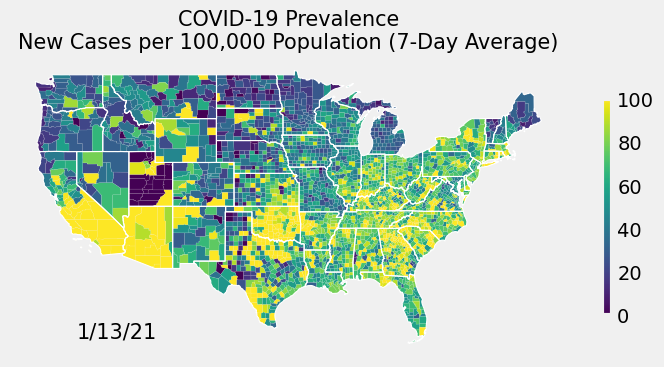

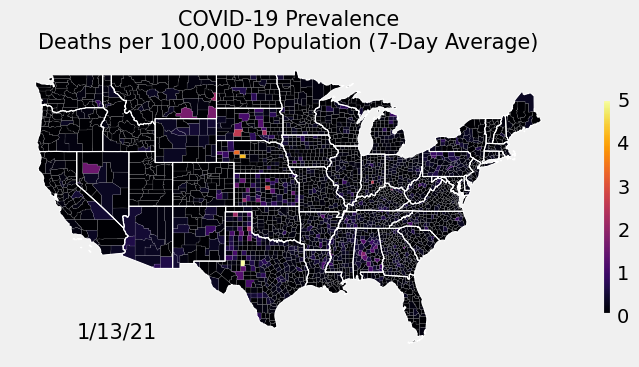

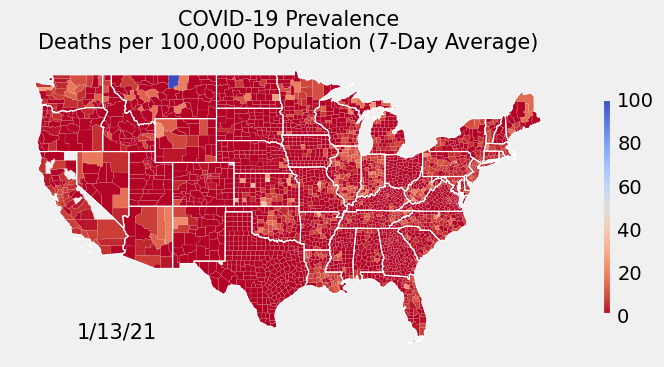

Done...
Done!


In [40]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [41]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [42]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [43]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [44]:
county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1048944      17836       16926        115    23564.428571   
335  2020-12-22  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1063082      18052       21429        266    23672.428571   
336  2020-12-23  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1076133      18261       27189        425    23800.714286   
337  2020-12-24  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1090814      18443       27732        391    23937.000000   
338  2020-12-25  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497     1098729      18548       22596        287    23089.714286   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
646  2021-10-29  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3171815      52280        9761         82     6743.000000   
647  2021-10-30  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3172871      52277        7237         42     6802.714286   
648  2021-10-31  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3173622      52282        1807          2     6770.428571   
649  2021-11-01  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3180304      52329        7433         52     7084.285714   
650  2021-11-02  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3183081      52360        9459         78     7164.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       289.285714      125.2661       1.537813              100          1.537813                      0.0                      0            0.0              0.0  total_30  
335       290.285714    125.840217       1.543129              100          1.543129                      0.0                      0            0.0              0.0  total_30  
336       295.571429     126.52217       1.571228              100          1.571228                      0.0                      0            0.0              0.0  total_30  
337       294.285714    127.246651       1.564393              100          1.564393                      0.0                      0            0.0              0.0  total_30  
338       288.285714    122.742567       1.532497              100          1.532497                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
646        69.285714     24.659139       0.253378        24.659139          0.253378                73.201729               20016889       81.81585       22372406.0  total_70  
647        67.142857     24.877514       0.245541        24.877514          0.245541                73.269113               20035315      81.919033       22400621.0  total_70  
648        65.428571     24.759446       0.239272        24.759446          0.239272                73.338321               20054240      82.015702       22427055.0  total_7

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [45]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 2)

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0015 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/07 total_30 0 total_30 0.0 0% 0%
10 2020/02/07 total_35 0 total_35 0.0 0% 0%
11 2020/02/07 total_40 0 total_40 0.0 0% 0%
12 2020/02/07 total_45 0 total_45 0.0 0% 0%
13 2020/02/07 total_50 0 total_50 0.0 0% 0%
14 2020/02/07 total_55 0 total_55 0.0 0% 0%
15 2020/02/07 total_60 1 total_60 0.0015 0% 0%
16 2020/02/07 total_65 0 total_65 0.0 0% 0%
17 2020/02/07 total_70 0 total_70 0.0 0% 0%
18 2020/02/08 total_30 0 total_30 0.0 0% 0%
19 2020/02/08 total_35 0 total_35 0.0 0% 0%
20 2020/02/08 total_40 0 total_40 0.0 0% 0%
21 2020/02/08 total_45 0 total_45 0.0 0% 0%
22 2020/02/08 total_50 0 total_50 0.

272 2020/03/07 total_40 0 total_40 0.0 0.0% 0%
273 2020/03/07 total_45 4 total_45 0.0113 106.6% 0%
274 2020/03/07 total_50 13 total_50 0.0227 214.15% 0%
275 2020/03/07 total_55 23 total_55 0.0409 385.85% 0%
276 2020/03/07 total_60 25 total_60 0.0377 355.66% 0%
277 2020/03/07 total_65 36 total_65 0.1545 1457.55% 0%
278 2020/03/07 total_70 128 total_70 0.4681 4416.04% 0%
279 2020/03/08 total_30 1 total_30 0.0053 100.0% 0%
280 2020/03/08 total_35 2 total_35 0.012 226.42% 0%
281 2020/03/08 total_40 0 total_40 0.0 0.0% 0%
282 2020/03/08 total_45 8 total_45 0.0227 428.3% 0%
283 2020/03/08 total_50 14 total_50 0.0245 462.26% 0%
284 2020/03/08 total_55 24 total_55 0.0427 805.66% 0%
285 2020/03/08 total_60 33 total_60 0.0498 939.62% 0%
286 2020/03/08 total_65 45 total_65 0.1931 3643.4% 0%
287 2020/03/08 total_70 163 total_70 0.5961 11247.17% 0%
288 2020/03/09 total_30 3 total_30 0.0159 100.0% 0%
289 2020/03/09 total_35 4 total_35 0.0239 150.31% 0%
290 2020/03/09 total_40 4 total_40 0.0161 101.2

533 2020/04/05 total_40 1808 total_40 7.2875 98.55% 0%
534 2020/04/05 total_45 3923 total_45 11.1196 150.38% 0%
535 2020/04/05 total_50 4808 total_50 8.4011 113.61% 0%
536 2020/04/05 total_55 8408 total_55 14.9446 202.11% 0%
537 2020/04/05 total_60 19753 total_60 29.8154 403.22% 0%
538 2020/04/05 total_65 9326 total_65 40.0125 541.12% 0%
539 2020/04/05 total_70 12128 total_70 44.3521 599.81% 0%
540 2020/04/06 total_30 1388 total_30 7.3785 100.0% 0%
541 2020/04/06 total_35 862 total_35 5.1611 69.95% 0%
542 2020/04/06 total_40 1625 total_40 6.5499 88.77% 0%
543 2020/04/06 total_45 3877 total_45 10.9893 148.94% 0%
544 2020/04/06 total_50 4322 total_50 7.5519 102.35% 0%
545 2020/04/06 total_55 7915 total_55 14.0684 190.67% 0%
546 2020/04/06 total_60 19211 total_60 28.9973 393.0% 0%
547 2020/04/06 total_65 9061 total_65 38.8755 526.88% 0%
548 2020/04/06 total_70 12444 total_70 45.5077 616.76% 0%
549 2020/04/07 total_30 2249 total_30 11.9555 100.0% 0%
550 2020/04/07 total_35 1029 total_35 6.

801 2020/05/05 total_30 1890 total_30 10.047 100.0% 0%
802 2020/05/05 total_35 1840 total_35 11.0166 109.65% 0%
803 2020/05/05 total_40 2379 total_40 9.589 95.44% 0%
804 2020/05/05 total_45 3415 total_45 9.6797 96.34% 0%
805 2020/05/05 total_50 5472 total_50 9.5613 95.17% 0%
806 2020/05/05 total_55 8576 total_55 15.2432 151.72% 0%
807 2020/05/05 total_60 13851 total_60 20.9069 208.09% 0%
808 2020/05/05 total_65 5875 total_65 25.2062 250.88% 0%
809 2020/05/05 total_70 5240 total_70 19.1627 190.73% 0%
810 2020/05/06 total_30 1925 total_30 10.2331 100.0% 0%
811 2020/05/06 total_35 1841 total_35 11.0226 107.72% 0%
812 2020/05/06 total_40 2626 total_40 10.5846 103.43% 0%
813 2020/05/06 total_45 3393 total_45 9.6174 93.98% 0%
814 2020/05/06 total_50 6286 total_50 10.9836 107.33% 0%
815 2020/05/06 total_55 8367 total_55 14.8718 145.33% 0%
816 2020/05/06 total_60 14022 total_60 21.165 206.83% 0%
817 2020/05/06 total_65 5995 total_65 25.7211 251.35% 0%
818 2020/05/06 total_70 4144 total_70 15.1

1099 2020/06/07 total_35 2089 total_35 12.5075 174.8% 0%
1100 2020/06/07 total_40 2435 total_40 9.8148 137.17% 0%
1101 2020/06/07 total_45 3879 total_45 10.9949 153.66% 0%
1102 2020/06/07 total_50 7159 total_50 12.509 174.82% 0%
1103 2020/06/07 total_55 6650 total_55 11.8199 165.19% 0%
1104 2020/06/07 total_60 9616 total_60 14.5145 202.85% 0%
1105 2020/06/07 total_65 2833 total_65 12.1548 169.87% 0%
1106 2020/06/07 total_70 2678 total_70 9.7934 136.87% 0%
1107 2020/06/08 total_30 1458 total_30 7.7506 100.0% 0%
1108 2020/06/08 total_35 1709 total_35 10.2323 132.02% 0%
1109 2020/06/08 total_40 2120 total_40 8.5451 110.25% 0%
1110 2020/06/08 total_45 3631 total_45 10.292 132.79% 0%
1111 2020/06/08 total_50 6553 total_50 11.4502 147.73% 0%
1112 2020/06/08 total_55 5796 total_55 10.302 132.92% 0%
1113 2020/06/08 total_60 9177 total_60 13.8519 178.72% 0%
1114 2020/06/08 total_65 2334 total_65 10.0138 129.2% 0%
1115 2020/06/08 total_70 2512 total_70 9.1864 118.53% 0%
1116 2020/06/09 total_30 

1385 2020/07/08 total_70 8754 total_70 32.0134 76.61% 0%
1386 2020/07/09 total_30 7297 total_30 38.7901 100.0% 0%
1387 2020/07/09 total_35 6734 total_35 40.3185 103.94% 0%
1388 2020/07/09 total_40 9640 total_40 38.8559 100.17% 0%
1389 2020/07/09 total_45 13323 total_45 37.7637 97.35% 0%
1390 2020/07/09 total_50 27814 total_50 48.5998 125.29% 0%
1391 2020/07/09 total_55 17421 total_55 30.9646 79.83% 0%
1392 2020/07/09 total_60 23630 total_60 35.6674 91.95% 0%
1393 2020/07/09 total_65 3950 total_65 16.9472 43.69% 0%
1394 2020/07/09 total_70 8456 total_70 30.9236 79.72% 0%
1395 2020/07/10 total_30 8691 total_30 46.2005 100.0% 0%
1396 2020/07/10 total_35 7215 total_35 43.1984 93.5% 0%
1397 2020/07/10 total_40 10236 total_40 41.2582 89.3% 0%
1398 2020/07/10 total_45 14371 total_45 40.7342 88.17% 0%
1399 2020/07/10 total_50 30252 total_50 52.8598 114.41% 0%
1400 2020/07/10 total_55 18785 total_55 33.389 72.27% 0%
1401 2020/07/10 total_60 25093 total_60 37.8757 81.98% 0%
1402 2020/07/10 total

1637 2020/08/05 total_70 6245 total_70 22.838 45.42% 0%
1638 2020/08/06 total_30 9783 total_30 52.0054 100.0% 0%
1639 2020/08/06 total_35 8277 total_35 49.5569 95.29% 0%
1640 2020/08/06 total_40 10064 total_40 40.565 78.0% 0%
1641 2020/08/06 total_45 11932 total_45 33.8209 65.03% 0%
1642 2020/08/06 total_50 21922 total_50 38.3046 73.66% 0%
1643 2020/08/06 total_55 15944 total_55 28.3394 54.49% 0%
1644 2020/08/06 total_60 21951 total_60 33.1331 63.71% 0%
1645 2020/08/06 total_65 4649 total_65 19.9462 38.35% 0%
1646 2020/08/06 total_70 7217 total_70 26.3926 50.75% 0%
1647 2020/08/07 total_30 10433 total_30 55.4608 100.0% 0%
1648 2020/08/07 total_35 8498 total_35 50.8801 91.74% 0%
1649 2020/08/07 total_40 11171 total_40 45.0269 81.19% 0%
1650 2020/08/07 total_45 13268 total_45 37.6078 67.81% 0%
1651 2020/08/07 total_50 23038 total_50 40.2546 72.58% 0%
1652 2020/08/07 total_55 16436 total_55 29.2139 52.67% 0%
1653 2020/08/07 total_60 20751 total_60 31.3218 56.48% 0%
1654 2020/08/07 total_6

1910 2020/09/05 total_40 9590 total_40 38.6544 99.75% 0%
1911 2020/09/05 total_45 11480 total_45 32.5398 83.97% 0%
1912 2020/09/05 total_50 17453 total_50 30.4959 78.69% 0%
1913 2020/09/05 total_55 16465 total_55 29.2654 75.52% 0%
1914 2020/09/05 total_60 13992 total_60 21.1197 54.5% 0%
1915 2020/09/05 total_65 4000 total_65 17.1617 44.28% 0%
1916 2020/09/05 total_70 4994 total_70 18.263 47.13% 0%
1917 2020/09/06 total_30 6087 total_30 32.3579 100.0% 0%
1918 2020/09/06 total_35 5133 total_35 30.7328 94.98% 0%
1919 2020/09/06 total_40 7607 total_40 30.6615 94.76% 0%
1920 2020/09/06 total_45 8648 total_45 24.5125 75.75% 0%
1921 2020/09/06 total_50 13748 total_50 24.0221 74.24% 0%
1922 2020/09/06 total_55 12582 total_55 22.3636 69.11% 0%
1923 2020/09/06 total_60 10827 total_60 16.3424 50.51% 0%
1924 2020/09/06 total_65 3384 total_65 14.5188 44.87% 0%
1925 2020/09/06 total_70 4272 total_70 15.6227 48.28% 0%
1926 2020/09/07 total_30 3773 total_30 20.0569 100.0% 0%
1927 2020/09/07 total_35 3

2187 2020/10/06 total_30 5387 total_30 28.6367 100.0% 0%
2188 2020/10/06 total_35 6346 total_35 37.9954 132.68% 0%
2189 2020/10/06 total_40 8117 total_40 32.7172 114.25% 0%
2190 2020/10/06 total_45 11413 total_45 32.3498 112.97% 0%
2191 2020/10/06 total_50 15422 total_50 26.9471 94.1% 0%
2192 2020/10/06 total_55 16030 total_55 28.4922 99.5% 0%
2193 2020/10/06 total_60 10600 total_60 15.9998 55.87% 0%
2194 2020/10/06 total_65 4193 total_65 17.9897 62.82% 0%
2195 2020/10/06 total_70 3719 total_70 13.6004 47.49% 0%
2196 2020/10/07 total_30 6753 total_30 35.8983 100.0% 0%
2197 2020/10/07 total_35 7151 total_35 42.8152 119.27% 0%
2198 2020/10/07 total_40 9545 total_40 38.473 107.17% 0%
2199 2020/10/07 total_45 12327 total_45 34.9406 97.33% 0%
2200 2020/10/07 total_50 17335 total_50 30.2897 84.38% 0%
2201 2020/10/07 total_55 19003 total_55 33.7765 94.09% 0%
2202 2020/10/07 total_60 13569 total_60 20.4812 57.05% 0%
2203 2020/10/07 total_65 4588 total_65 19.6844 54.83% 0%
2204 2020/10/07 total

2438 2020/11/02 total_70 8065 total_70 29.4937 40.46% 0%
2439 2020/11/03 total_30 34536 total_30 183.5899 100.0% 0%
2440 2020/11/03 total_35 15986 total_35 95.713 52.13% 0%
2441 2020/11/03 total_40 16468 total_40 66.3775 36.16% 0%
2442 2020/11/03 total_45 21662 total_45 61.4004 33.44% 0%
2443 2020/11/03 total_50 33631 total_50 58.7639 32.01% 0%
2444 2020/11/03 total_55 32531 total_55 57.8216 31.49% 0%
2445 2020/11/03 total_60 27710 total_60 41.8258 22.78% 0%
2446 2020/11/03 total_65 13624 total_65 58.4527 31.84% 0%
2447 2020/11/03 total_70 9656 total_70 35.312 19.23% 0%
2448 2020/11/04 total_30 37049 total_30 196.9487 100.0% 0%
2449 2020/11/04 total_35 18212 total_35 109.0408 55.37% 0%
2450 2020/11/04 total_40 19325 total_40 77.8933 39.55% 0%
2451 2020/11/04 total_45 24171 total_45 68.5121 34.79% 0%
2452 2020/11/04 total_50 35683 total_50 62.3494 31.66% 0%
2453 2020/11/04 total_55 36768 total_55 65.3526 33.18% 0%
2454 2020/11/04 total_60 32604 total_60 49.2129 24.99% 0%
2455 2020/11/04

2723 2020/12/04 total_55 73914 total_55 131.377 101.01% 0%
2724 2020/12/04 total_60 85877 total_60 129.6238 99.67% 0%
2725 2020/12/04 total_65 33107 total_65 142.0429 109.21% 0%
2726 2020/12/04 total_70 27675 total_70 101.2074 77.82% 0%
2727 2020/12/05 total_30 23640 total_30 125.6678 100.0% 0%
2728 2020/12/05 total_35 26384 total_35 157.969 125.7% 0%
2729 2020/12/05 total_40 37024 total_40 149.2326 118.75% 0%
2730 2020/12/05 total_45 54627 total_45 154.8388 123.21% 0%
2731 2020/12/05 total_50 83578 total_50 146.0371 116.21% 0%
2732 2020/12/05 total_55 74237 total_55 131.9511 105.0% 0%
2733 2020/12/05 total_60 85188 total_60 128.5838 102.32% 0%
2734 2020/12/05 total_65 29703 total_65 127.4383 101.41% 0%
2735 2020/12/05 total_70 27653 total_70 101.127 80.47% 0%
2736 2020/12/06 total_30 17675 total_30 93.9585 100.0% 0%
2737 2020/12/06 total_35 21318 total_35 127.6374 135.84% 0%
2738 2020/12/06 total_40 31286 total_40 126.1044 134.21% 0%
2739 2020/12/06 total_45 45499 total_45 128.9657 13

2987 2021/01/02 total_70 33333 total_70 121.8987 81.04% 0.0%
2988 2021/01/03 total_30 23510 total_30 124.9768 100.0% 0.0%
2989 2021/01/03 total_35 24995 total_35 149.6527 119.74% 0.0%
2990 2021/01/03 total_40 37816 total_40 152.4249 121.96% 0.0%
2991 2021/01/03 total_45 53838 total_45 152.6024 122.1% 0.0%
2992 2021/01/03 total_50 109694 total_50 191.67 153.36% 0.0%
2993 2021/01/03 total_55 78113 total_55 138.8405 111.09% 0.0%
2994 2021/01/03 total_60 99779 total_60 150.6077 120.51% 0.0%
2995 2021/01/03 total_65 27449 total_65 117.7677 94.23% 0.0%
2996 2021/01/03 total_70 34087 total_70 124.6561 99.74% 0.0%
2997 2021/01/04 total_30 18049 total_30 95.9466 100.0% 0.0%
2998 2021/01/04 total_35 19166 total_35 114.7527 119.6% 0.0%
2999 2021/01/04 total_40 28434 total_40 114.6089 119.45% 0.0%
3000 2021/01/04 total_45 40127 total_45 113.7389 118.54% 0.0%
3001 2021/01/04 total_50 82435 total_50 144.0399 150.13% 0.0%
3002 2021/01/04 total_55 60282 total_55 107.1471 111.67% 0.0%
3003 2021/01/04 t

3265 2021/02/02 total_65 14624 total_65 62.7431 81.78% 2.2%
3266 2021/02/02 total_70 19005 total_70 69.5013 90.59% 0.0%
3267 2021/02/03 total_30 16010 total_30 85.1075 100.0% 0.0%
3268 2021/02/03 total_35 12997 total_35 77.817 91.43% 0.8%
3269 2021/02/03 total_40 21302 total_40 85.8619 100.89% 1.5%
3270 2021/02/03 total_45 27772 total_45 78.719 92.49% 2.7%
3271 2021/02/03 total_50 44148 total_50 77.1405 90.64% 3.1%
3272 2021/02/03 total_55 35846 total_55 63.7138 74.86% 1.2%
3273 2021/02/03 total_60 48246 total_60 72.8231 85.57% 1.3%
3274 2021/02/03 total_65 13437 total_65 57.6504 67.74% 2.6%
3275 2021/02/03 total_70 18290 total_70 66.8865 78.59% 0.0%
3276 2021/02/04 total_30 17270 total_30 91.8056 100.0% 0.0%
3277 2021/02/04 total_35 13832 total_35 82.8164 90.21% 0.8%
3278 2021/02/04 total_40 22780 total_40 91.8193 100.01% 2.2%
3279 2021/02/04 total_45 29571 total_45 83.8182 91.3% 2.8%
3280 2021/02/04 total_50 47119 total_50 82.3317 89.68% 3.2%
3281 2021/02/04 total_55 37608 total_55 6

3544 2021/03/05 total_65 10817 total_65 46.4095 129.7% 15.4%
3545 2021/03/05 total_70 13306 total_70 48.66 135.99% 4.2%
3546 2021/03/06 total_30 6288 total_30 33.4264 100.0% 0.0%
3547 2021/03/06 total_35 4952 total_35 29.6491 88.7% 7.3%
3548 2021/03/06 total_40 8566 total_40 34.527 103.29% 11.0%
3549 2021/03/06 total_45 11813 total_45 33.4836 100.17% 9.6%
3550 2021/03/06 total_50 19205 total_50 33.5572 100.39% 9.7%
3551 2021/03/06 total_55 20843 total_55 37.047 110.83% 6.3%
3552 2021/03/06 total_60 28011 total_60 42.2801 126.49% 6.8%
3553 2021/03/06 total_65 10458 total_65 44.8692 134.23% 15.8%
3554 2021/03/06 total_70 12947 total_70 47.3472 141.65% 4.2%
3555 2021/03/07 total_30 5336 total_30 28.3656 100.0% 0.0%
3556 2021/03/07 total_35 3962 total_35 23.7217 83.63% 7.4%
3557 2021/03/07 total_40 5771 total_40 23.2612 82.0% 11.2%
3558 2021/03/07 total_45 8612 total_45 24.4105 86.06% 9.6%
3559 2021/03/07 total_50 14853 total_50 25.9529 91.49% 9.8%
3560 2021/03/07 total_55 16348 total_55 2

3818 2021/04/05 total_40 4779 total_40 19.2627 116.1% 15.3%
3819 2021/04/05 total_45 11080 total_45 31.406 189.3% 17.6%
3820 2021/04/05 total_50 15882 total_50 27.7509 167.27% 23.5%
3821 2021/04/05 total_55 19216 total_55 34.1551 205.87% 14.0%
3822 2021/04/05 total_60 27361 total_60 41.299 248.93% 15.7%
3823 2021/04/05 total_65 11041 total_65 47.3705 285.52% 25.7%
3824 2021/04/05 total_70 11724 total_70 42.8746 258.42% 16.4%
3825 2021/04/06 total_30 3722 total_30 19.7858 100.0% 0.0%
3826 2021/04/06 total_35 4760 total_35 28.4996 144.04% 10.2%
3827 2021/04/06 total_40 6921 total_40 27.8965 140.99% 15.5%
3828 2021/04/06 total_45 15929 total_45 45.1503 228.2% 17.6%
3829 2021/04/06 total_50 21278 total_50 37.1794 187.91% 23.9%
3830 2021/04/06 total_55 24204 total_55 43.0209 217.43% 14.1%
3831 2021/04/06 total_60 31588 total_60 47.6793 240.98% 16.0%
3832 2021/04/06 total_65 12784 total_65 54.8487 277.21% 25.9%
3833 2021/04/06 total_70 12113 total_70 44.2972 223.88% 16.5%
3834 2021/04/07 tot

4106 2021/05/07 total_40 6538 total_40 26.3527 109.7% 21.0%
4107 2021/05/07 total_45 11159 total_45 31.6299 131.67% 28.5%
4108 2021/05/07 total_50 16534 total_50 28.8901 120.26% 37.7%
4109 2021/05/07 total_55 17908 total_55 31.8302 132.5% 29.7%
4110 2021/05/07 total_60 17579 total_60 26.534 110.45% 27.2%
4111 2021/05/07 total_65 6865 total_65 29.4537 122.61% 43.6%
4112 2021/05/07 total_70 6053 total_70 22.1358 92.15% 41.6%
4113 2021/05/08 total_30 3986 total_30 21.1892 100.0% 0.0%
4114 2021/05/08 total_35 3632 total_35 21.7459 102.63% 14.0%
4115 2021/05/08 total_40 5309 total_40 21.399 100.99% 21.2%
4116 2021/05/08 total_45 8943 total_45 25.3487 119.63% 28.7%
4117 2021/05/08 total_50 14824 total_50 25.9022 122.24% 37.9%
4118 2021/05/08 total_55 14979 total_55 26.6241 125.65% 30.6%
4119 2021/05/08 total_60 16370 total_60 24.7091 116.61% 27.7%
4120 2021/05/08 total_65 5940 total_65 25.4851 120.27% 44.1%
4121 2021/05/08 total_70 5847 total_70 21.3825 100.91% 43.5%
4122 2021/05/09 total_30

4367 2021/06/05 total_40 2656 total_40 10.7055 121.24% 23.0%
4368 2021/06/05 total_45 3453 total_45 9.7874 110.85% 35.2%
4369 2021/06/05 total_50 5641 total_50 9.8566 111.63% 42.4%
4370 2021/06/05 total_55 5958 total_55 10.5899 119.93% 36.1%
4371 2021/06/05 total_60 4762 total_60 7.1878 81.4% 36.0%
4372 2021/06/05 total_65 1862 total_65 7.9888 90.48% 51.1%
4373 2021/06/05 total_70 2729 total_70 9.9799 113.03% 55.6%
4374 2021/06/06 total_30 811 total_30 4.3112 100.0% 0.0%
4375 2021/06/06 total_35 608 total_35 3.6403 84.44% 16.1%
4376 2021/06/06 total_40 1171 total_40 4.7199 109.48% 23.0%
4377 2021/06/06 total_45 1666 total_45 4.7222 109.53% 35.4%
4378 2021/06/06 total_50 4128 total_50 7.2129 167.31% 42.5%
4379 2021/06/06 total_55 3448 total_55 6.1286 142.16% 36.3%
4380 2021/06/06 total_60 3862 total_60 5.8294 135.22% 36.3%
4381 2021/06/06 total_65 1418 total_65 6.0838 141.12% 51.3%
4382 2021/06/06 total_70 2412 total_70 8.8207 204.6% 55.7%
4383 2021/06/07 total_30 1301 total_30 6.916 10

4641 2021/07/05 total_60 1734 total_60 2.6173 85.04% 42.6%
4642 2021/07/05 total_65 611 total_65 2.6214 85.17% 56.2%
4643 2021/07/05 total_70 1509 total_70 5.5184 179.29% 62.2%
4644 2021/07/06 total_30 2365 total_30 12.5721 100.0% 0.0%
4645 2021/07/06 total_35 2075 total_35 12.4237 98.82% 17.6%
4646 2021/07/06 total_40 3456 total_40 13.9301 110.8% 24.6%
4647 2021/07/06 total_45 5259 total_45 14.9065 118.57% 38.4%
4648 2021/07/06 total_50 5610 total_50 9.8024 77.97% 44.8%
4649 2021/07/06 total_55 4643 total_55 8.2526 65.64% 40.2%
4650 2021/07/06 total_60 3610 total_60 5.449 43.34% 42.6%
4651 2021/07/06 total_65 987 total_65 4.2346 33.68% 56.2%
4652 2021/07/06 total_70 2040 total_70 7.4603 59.34% 62.2%
4653 2021/07/07 total_30 4047 total_30 21.5134 100.0% 0.0%
4654 2021/07/07 total_35 3577 total_35 21.4166 99.55% 17.6%
4655 2021/07/07 total_40 5975 total_40 24.0834 111.95% 24.6%
4656 2021/07/07 total_45 7633 total_45 21.6355 100.57% 38.6%
4657 2021/07/07 total_50 8404 total_50 14.6844 68

4904 2021/08/03 total_70 9034 total_70 33.0373 32.53% 63.7%
4905 2021/08/04 total_30 19974 total_30 106.1797 100.0% 0.0%
4906 2021/08/04 total_35 15933 total_35 95.3957 89.84% 18.6%
4907 2021/08/04 total_40 24444 total_40 98.5264 92.79% 25.9%
4908 2021/08/04 total_45 26448 total_45 74.9662 70.6% 40.0%
4909 2021/08/04 total_50 38002 total_50 66.4015 62.54% 45.6%
4910 2021/08/04 total_55 28939 total_55 51.4371 48.44% 41.7%
4911 2021/08/04 total_60 31353 total_60 47.3246 44.57% 46.2%
4912 2021/08/04 total_65 7183 total_65 30.8181 29.02% 58.2%
4913 2021/08/04 total_70 9126 total_70 33.3738 31.43% 63.7%
4914 2021/08/05 total_30 18274 total_30 97.1427 100.0% 0.0%
4915 2021/08/05 total_35 17272 total_35 103.4127 106.45% 18.6%
4916 2021/08/05 total_40 25831 total_40 104.117 107.18% 25.9%
4917 2021/08/05 total_45 28417 total_45 80.5472 82.92% 40.0%
4918 2021/08/05 total_50 39365 total_50 68.7831 70.81% 45.6%
4919 2021/08/05 total_55 30465 total_55 54.1494 55.74% 41.8%
4920 2021/08/05 total_60 3

5184 2021/09/04 total_30 26178 total_30 139.1596 100.0% 0.0%
5185 2021/09/04 total_35 22462 total_35 134.4868 96.64% 20.6%
5186 2021/09/04 total_40 32732 total_40 131.9328 94.81% 28.6%
5187 2021/09/04 total_45 40036 total_45 113.481 81.55% 41.7%
5188 2021/09/04 total_50 77323 total_50 135.1076 97.09% 47.8%
5189 2021/09/04 total_55 60457 total_55 107.4581 77.22% 43.7%
5190 2021/09/04 total_60 62292 total_60 94.0243 67.57% 51.0%
5191 2021/09/04 total_65 9836 total_65 42.2006 30.33% 61.1%
5192 2021/09/04 total_70 21531 total_70 78.7388 56.58% 65.6%
5193 2021/09/05 total_30 8056 total_30 42.8249 100.0% 0.0%
5194 2021/09/05 total_35 7562 total_35 45.276 105.72% 20.7%
5195 2021/09/05 total_40 9370 total_40 37.7676 88.19% 28.7%
5196 2021/09/05 total_45 9351 total_45 26.5052 61.89% 41.7%
5197 2021/09/05 total_50 19480 total_50 34.0377 79.48% 47.8%
5198 2021/09/05 total_55 19243 total_55 34.2031 79.87% 43.8%
5199 2021/09/05 total_60 13760 total_60 20.7695 48.5% 51.2%
5200 2021/09/05 total_65 51

5449 2021/10/03 total_50 13090 total_50 22.8724 95.34% 49.7%
5450 2021/10/03 total_55 13349 total_55 23.7269 98.9% 55.1%
5451 2021/10/03 total_60 8353 total_60 12.6081 52.55% 56.9%
5452 2021/10/03 total_65 4902 total_65 21.0316 87.67% 63.9%
5453 2021/10/03 total_70 2155 total_70 7.8808 32.85% 67.4%
5454 2021/10/04 total_30 12554 total_30 66.7358 100.0% 0.0%
5455 2021/10/04 total_35 12490 total_35 74.7814 112.06% 22.8%
5456 2021/10/04 total_40 19103 total_40 76.9984 115.38% 31.6%
5457 2021/10/04 total_45 25207 total_45 71.4486 107.06% 43.8%
5458 2021/10/04 total_50 37303 total_50 65.1801 97.67% 49.7%
5459 2021/10/04 total_55 34314 total_55 60.9908 91.39% 55.3%
5460 2021/10/04 total_60 26012 total_60 39.2628 58.83% 57.0%
5461 2021/10/04 total_65 10349 total_65 44.4016 66.53% 63.9%
5462 2021/10/04 total_70 9002 total_70 32.9203 49.33% 67.5%
5463 2021/10/05 total_30 17469 total_30 92.8634 100.0% 0.0%
5464 2021/10/05 total_35 18524 total_35 110.9088 119.43% 22.8%
5465 2021/10/05 total_40 27

5719 2021/11/02 total_50 37460 total_50 65.4544 151.06% 51.1%
5720 2021/11/02 total_55 35769 total_55 63.5769 146.73% 56.6%
5721 2021/11/02 total_60 33725 total_60 50.9049 117.48% 61.3%
5722 2021/11/02 total_65 12292 total_65 52.7378 121.71% 65.4%
5723 2021/11/02 total_70 9459 total_70 34.5915 79.83% 76.0%
Done!


In [47]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70']
['#b40426', '#d95847', '#f18d6f', '#f7b89c', '#ead4c8', '#cdd9ec', '#aac7fd', '#82a6fb', '#5d7ce6']


In [48]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [49]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [50]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [51]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [52]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [53]:
whole_county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
16   2020-02-07  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
17   2020-02-08  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
18   2020-02-09  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
19   2020-02-10  [1083, 21227, 40127, 38057, 1081, 21147, 47153...    Bibb        Alabama    Bibb, Alabama, US   18811497           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
646  2021-10-29  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3171815      52280        9761         82     6743.000000   
647  2021-10-30  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3172871      52277        7237         42     6802.714286   
648  2021-10-31  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3173622      52282        1807          2     6770.428571   
649  2021-11-01  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3180304      52329        7433         52     7084.285714   
650  2021-11-02  [8013, 30005, 44009, 24027, 36119, 34027, 6013...  Apache        Arizona  Apache, Arizona, US   27344831     3183081      52360        9459         78     7164.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
646        69.285714     24.659139       0.253378        24.659139          0.253378  total_70  
647        67.142857     24.877514       0.245541        24.877514          0.245541  total_70  
648        65.428571     24.759446       0.239272        24.759446          0.239272  total_70  
649        65.142857     25.907221       0.238227        25.907221          0.238227  total_70  
650        61.571429     26.198736       0.225167        26.198736          0.225167  total_70  

[5724 rows x 17 columns]

In [54]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [55]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [56]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 825262,
  'confirm_start': 678573,
  'confirm_end': 1503835,
  'confirm_period_100k': 9107.690012179462,
  'confirm_deaths': 16284,
  'death_period_100k': 179.7121691757652,
  'vax_complete': 3975294,
  'vax_complete_100k': 43871.81944555419,
  'vax_partial': 4731256,
  'vax_partial_100k': 52214.7063796275,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 41721053,
  'pop_pct': 0.12751770819271183,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-02 00:00:00'),
  'confirm_period': 3425006,
  'confirm_start': 3246954,
  'confirm_end': 6671960,
  'confirm_period_100k': 8209.29903183412,
  'confirm_deaths': 56360,
  'death_period_100k': 135.08767384178918,
  'vax_complete': 20180437,
  'vax_complete_100k': 48369.91290704,
  'va

In [57]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [58]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [59]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [60]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [61]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [62]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                